In [ ]:
import math
import random

import pandas as pd
import numpy as np
from pandas import option_context

from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib.colors import ListedColormap

import warnings
warnings.simplefilter('ignore')

In [ ]:
rng = np.random.default_rng()
sns.set_style('whitegrid')

## Переобучение & недообучение

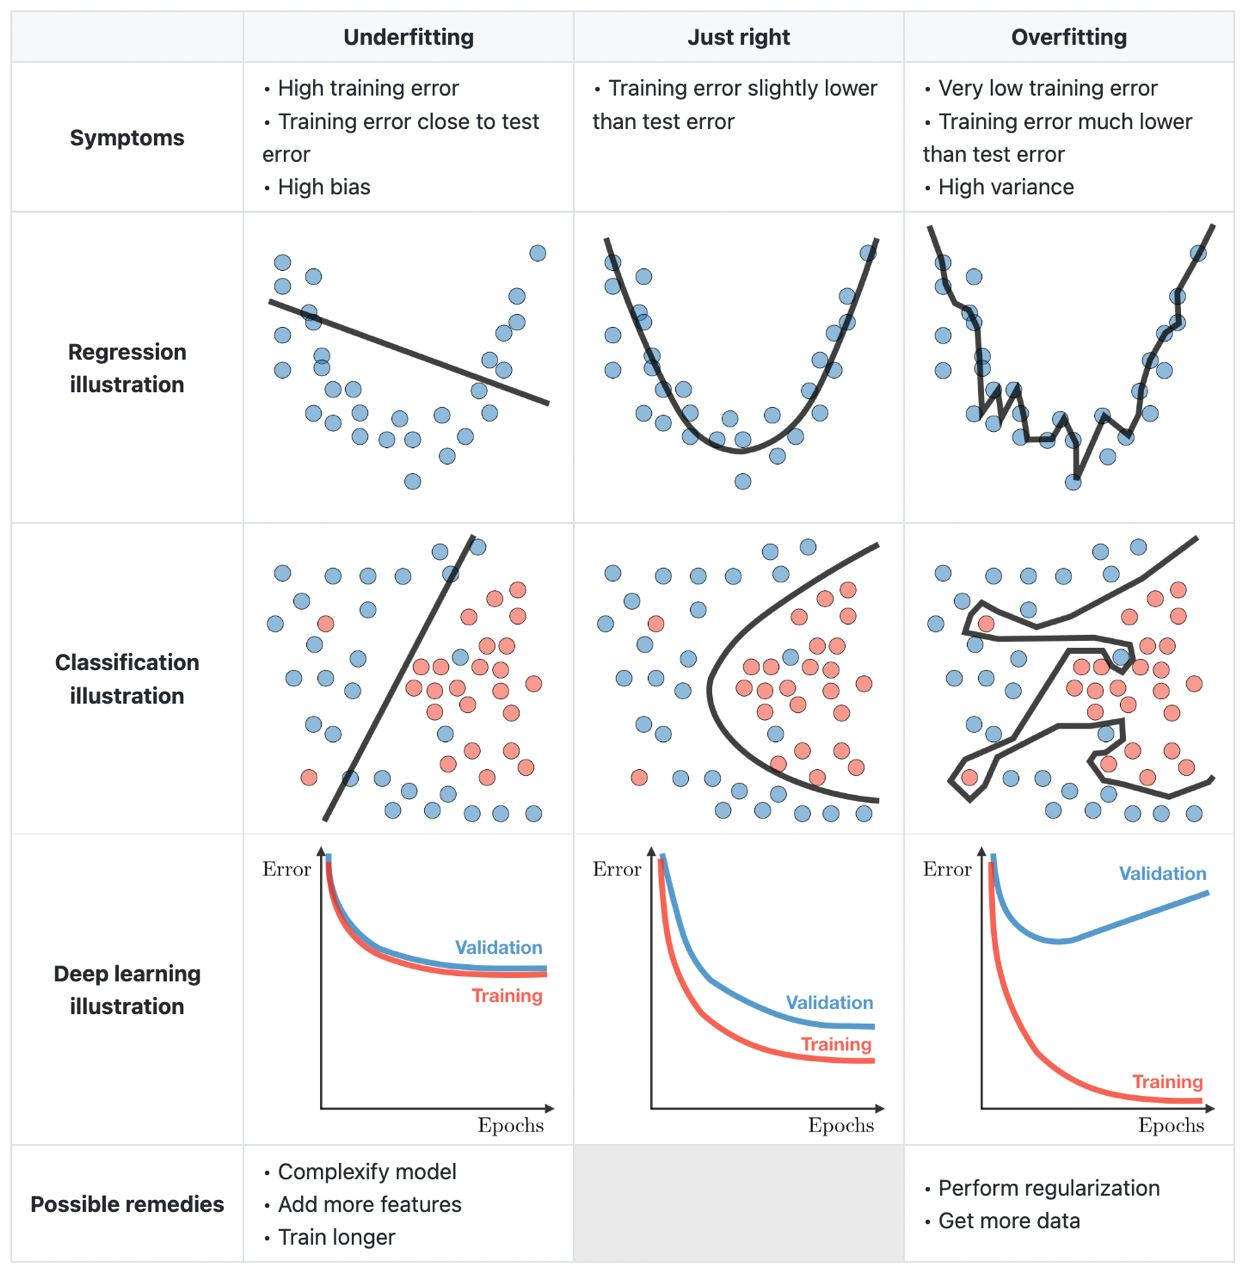

Линейные модели

[Курс «Машинное обучение» 2019, К. В. Воронцов](https://www.youtube.com/playlist?list=PLJOzdkh8T5krxc4HsHbB8g8f0hu7973fK)

[The Elements of Statistical Learning: Data Mining, Inference, and Prediction](https://t.me/programmist_of/308)

## Линейная регрессия

Строя модели машинного обучения мы фактически пытаемся найти функциональную зависимость между данными и целевой переменной.

Один из видов такой зависимости является линейная зависимость

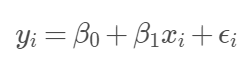

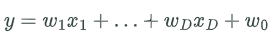

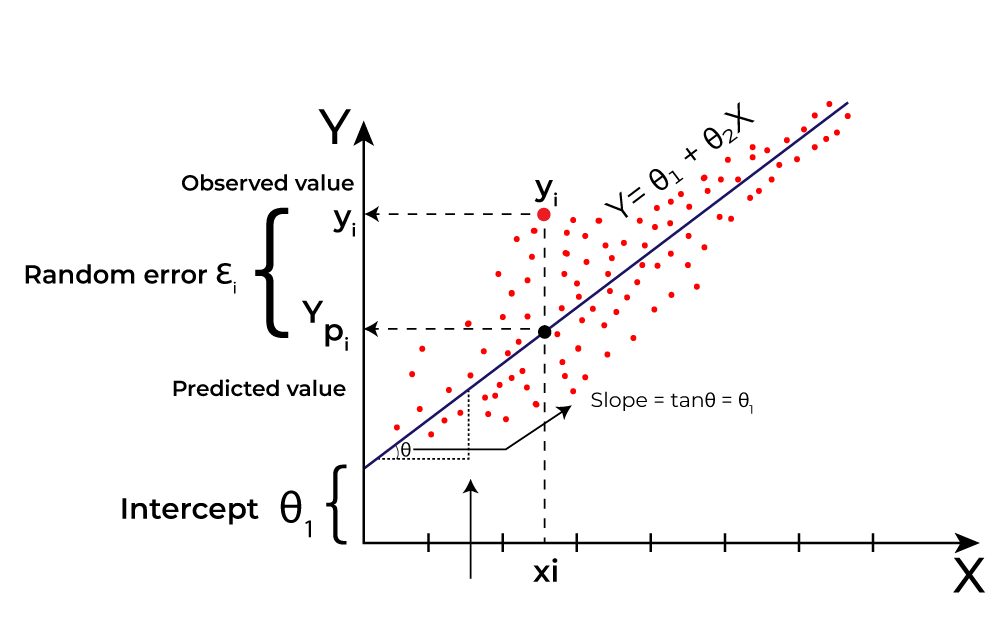

### Как найти весовые коэффициенты?

Попробуем случайные (ну а вдруг?)

In [ ]:
def plot_regression_line(x, y, y_pred):
  plt.plot(x, y, 'o', label='original data')
  plt.plot(x, y_pred, 'r', label='fitted line')
  plt.legend()
  plt.show()

In [ ]:
def regression_with_generated_weights(X, n=1):
  w, b = np.random.uniform(low=-10, high=10), np.random.uniform(low=-2, high=2)
  y_pred = w * x + b
  return y_pred

In [ ]:
x = rng.random(1000)
y = np.exp(1.6 * x + rng.random(1000))

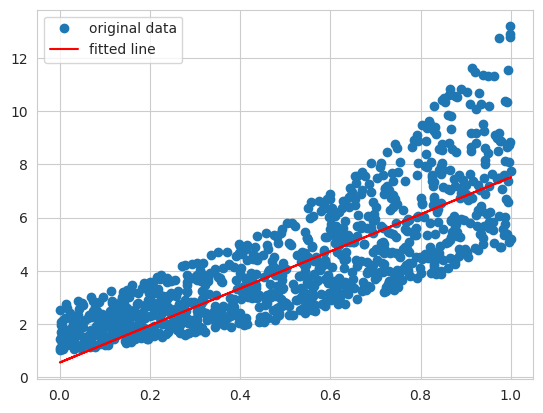

In [ ]:
y_pred = regression_with_generated_weights(x)
plot_regression_line(x, y, y_pred)

В принципе неплохо, но можно лучше...

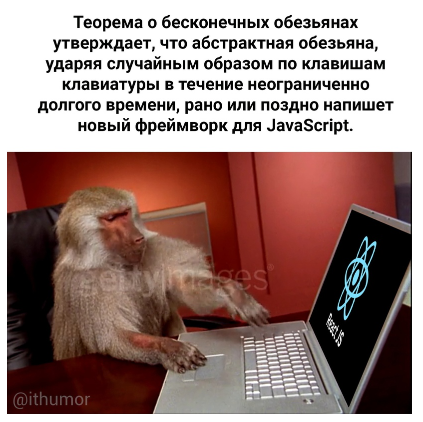

Если вдуматься, даже случайно подбирая веса, мы решаем оптимизационную задачу вида

$w^* = argmin(F(w | X, Y))$, где $F$ — некий функционал («ошибка алгоритма», функция потерь, loss function).


Мы хотим, чтобы на нашем датасете функция  как можно лучше приближала нашу зависимость. Для этого минимизируется MSE

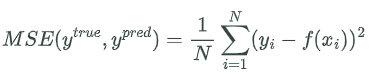


Или MAE (например, когда есть выбросы)

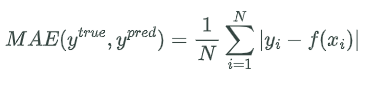

Или что-нибудь еще...

### Как будем решать оптимизационную задачу?

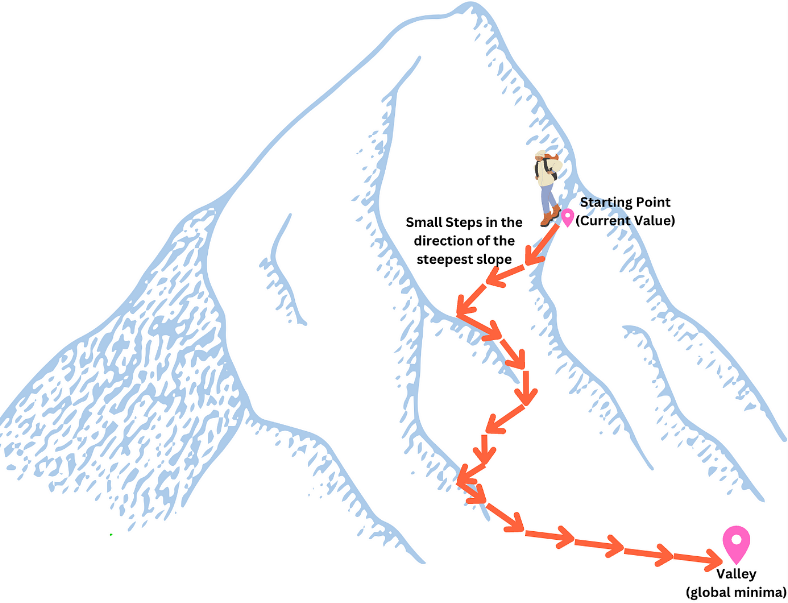

#### Немного о градиентном спуске

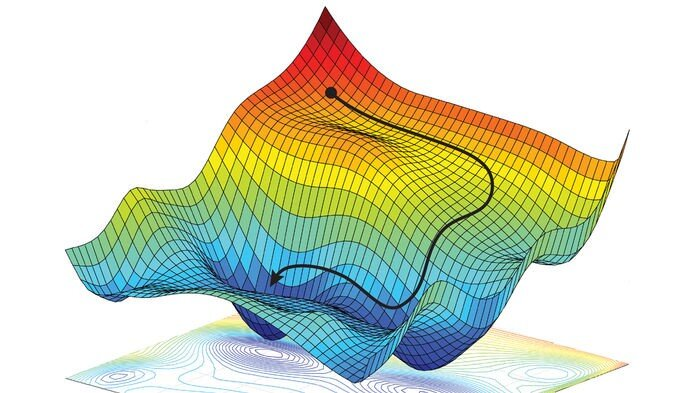

[Градиент](https://ru.wikipedia.org/wiki/%D0%93%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82) - вектор, своим направлением указывающий направление наискорейшего роста функции $\varphi$

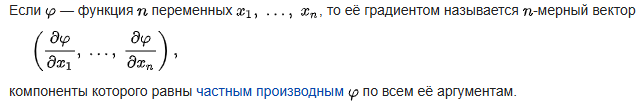

Так как мы ищем минимум функции потерь, то будем считать градиент для нее по параметрам модели - весам. При этом, нам нужно не направление возрастания, а направление убывания - антиградиент

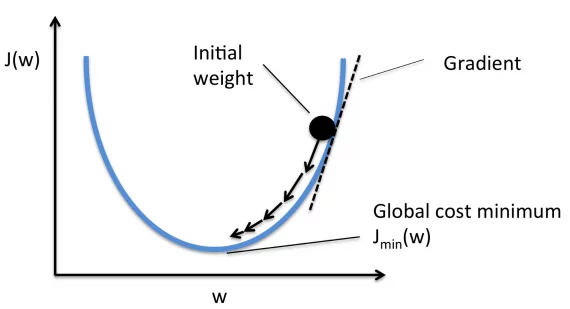

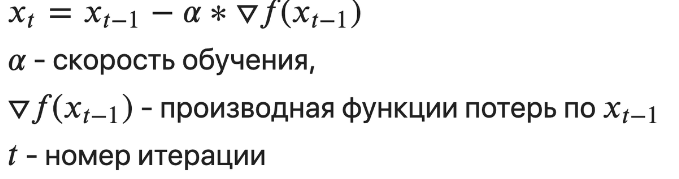

#### Код анимации GD

In [ ]:
# https://www.kaggle.com/code/trolukovich/animating-gradien-descent

def gradient_descent(
    function,
    derivative,
    start_x=-4,
    x_domain=(-5, 5, 0.1),
    iterations=1000,
    lr=0.1,
    precision=0.001,
    figsize=(10, 8),
    name='anim.gif',
    fps=5,
):
    '''
    Creates an animation of gradient descent from specific point to the closest local minimum and saves it at the "name" name.
    function - described function, must be passed as function
    derivative - derivative of "function", must be passed as function
    start_x - starting X coordinate of point
    x_range - domain of function as tuple - (left_bound, right_bound, step)
    iterations - maximum number of iteration before stop
    lr - learning rate
    precision - desired precision of result, if step of gradient descent will be smalle than precision, then algorithm will stop
    figsize - size of a plot
    name - name of animation to save
    fps - fps of animation
    '''

    images = []
    fig, ax = plt.subplots(figsize=figsize)
    x = np.arange(*x_domain)
    px = float(start_x) # Starting x coordinate

    # Function plot
    f = plt.plot(x, function(x), color='k')

    for frame in range(iterations):
        old_px = px # Saving old px value to calculate step

        # Plot point to track
        py = function(px) # Y coordinate of point
        point = plt.scatter(px, py, color='r', zorder=2.5)

        # Plot tangent line to the graph at (px, py) point
        slope = derivative(px)
        y_intercept = py - slope * px
        tx = np.arange(px - 1, px + 2, 2) # X coordinates of tangent line
        ty = slope * tx + y_intercept # Y coordinates of tangent line
        tangent = plt.plot(tx, ty, 'r--')

        # Calculate new value of px
        px = px - lr * slope
        step = abs(old_px - px)

        # Plot text info
        bbox_args = dict(boxstyle="round", fc="0.8")
        arrow_args = dict(arrowstyle = '->', color = 'b', linewidth = 1)
        text = f'Iteration: {frame}\nPoint: ({px:.2f}, {py:.2f})\nSlope: {slope:.2f}\nStep: {step:.4f}'
        text = ax.annotate(text, xy = (px, py), xytext = (0.7, 0.9), textcoords = 'axes fraction', bbox = bbox_args, arrowprops=arrow_args, fontsize = 12)

        plt.title('Gradient descent animation')

        # Stopping algorithm if desired precision have been met
        if step <= precision:
            text2 = plt.text(0.7, 0.1, 'Local minimum found', fontsize = 12, transform = ax.transAxes)
            images.append([f[0], tangent[0], point, text, text2])
            break

        images.append([f[0], tangent[0], point, text])

    anim = ArtistAnimation(fig, images)
    anim.save(name, writer = 'imagemagic', fps = fps)

#### Анимация

In [ ]:
def f(x):
    return x**2

def f_derivative(x):
    return 2 * x

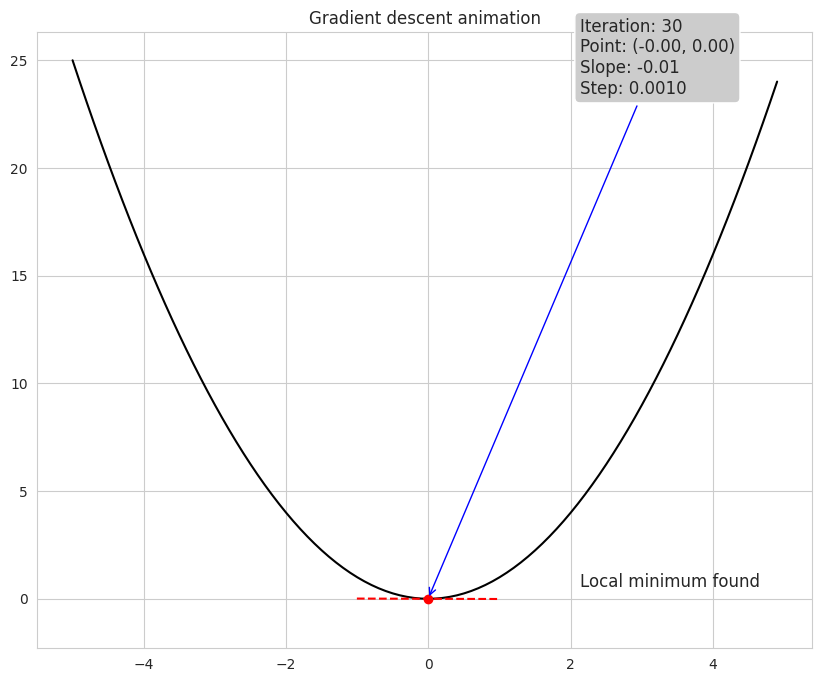

In [ ]:
gradient_descent(f, f_derivative, start_x=-4, lr=0.1, name='classic.gif')

#### Соберем все вместе

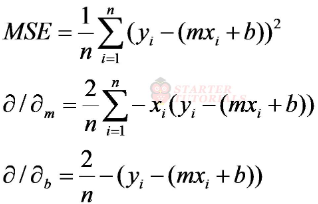

In [ ]:
def update_weights(w, b, X, Y, learning_rate):
    w_deriv = 0
    b_deriv = 0
    N = len(X)

    for i in range(N):
        # -2x(y - (wx + b))
        w_deriv += -2 * X[i] * (Y[i] - (w * X[i] + b))

        # -2(y - (wx + b))
        b_deriv += -2 * (Y[i] - (w * X[i] + b))

    # We subtract because the derivatives point in direction of steepest ascent
    w -= (w_deriv / N) * learning_rate
    b -= (b_deriv / N) * learning_rate

    return w, b

def cost_function(w, b, X, y):
    N = len(X)
    total_cost = 0
    for i in range(N):
        total_cost += math.pow((y[i] - (w * X[i] + b)), 2)
    return total_cost / N

def gradient_descent(X, y, learning_rate=0.001, tolerance=1e-2, max_iter=1000):
    w = 0
    b = 0
    error = []
    count = 0
    while True:
        w, b = update_weights(w, b, X, y, learning_rate)
        cur_cost = cost_function(w, b, X, y)
        error.append(cur_cost)
        count += 1
        if cur_cost < tolerance:
            break
        if count > max_iter:
            break
    return w, b, error

w, b, error = gradient_descent(x, y)
y_predict = [w * x[i] + b for i in range(len(x))]

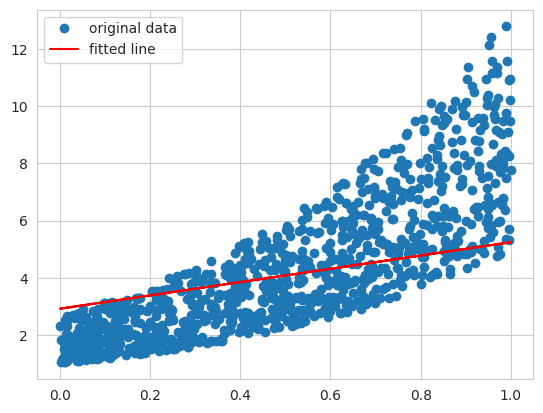

In [ ]:
plot_regression_line(x, y, y_predict)

### Готовая реализация в Scikit-Learn

In [ ]:
X, y =  load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.25)
X_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
422,-0.078165,0.050680,0.077863,0.052858,0.078236,0.064447,0.026550,-0.002592,0.040673,-0.009362
409,-0.052738,0.050680,-0.011595,0.056301,0.056221,0.072902,-0.039719,0.071210,0.030564,-0.005220
55,-0.041840,-0.044642,-0.049318,-0.036656,-0.007073,-0.022608,0.085456,-0.039493,-0.066490,0.007207
157,-0.001882,0.050680,-0.033151,-0.018306,0.031454,0.042840,-0.013948,0.019917,0.010227,0.027917
70,-0.001882,-0.044642,-0.069797,-0.012556,-0.000193,-0.009143,0.070730,-0.039493,-0.062917,0.040343


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)

In [ ]:
print(f'RMSE: {root_mean_squared_error(y_test, y_preds_lr)}')

RMSE: 56.74617932726026


In [ ]:
X_train.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,0.000521,-0.000005,0.001205,-0.000151,0.000917,0.000422,-0.000845,0.001105,0.002516,-0.000077
std,0.048223,0.047637,0.048400,0.047159,0.047697,0.047253,0.049024,0.047825,0.047772,0.048825
min,-0.107226,-0.044642,-0.084886,-0.112399,-0.126781,-0.115613,-0.102307,-0.076395,-0.126097,-0.137767
25%,-0.038207,-0.044642,-0.035307,-0.034935,-0.033216,-0.031689,-0.039719,-0.039493,-0.033246,-0.034215
50%,0.005383,-0.044642,-0.006206,-0.005670,-0.002945,-0.001627,-0.010266,-0.002592,0.001148,0.003064
75%,0.038076,0.050680,0.033134,0.035076,0.027326,0.031410,0.028391,0.034309,0.035162,0.027917
max,0.110727,0.050680,0.170555,0.125158,0.153914,0.155887,0.181179,0.155345,0.133597,0.135612


Возьмем задачу посложнее - предсказание возраста морского гребешка

Rings - value + 1.5 gives age in years (eg. 4 = 5.5 years)

In [ ]:
data = pd.read_csv('abalone.data.txt', header=None)
data.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'hucked_weight', 'viscera_weight', 'shell_weight', 'rings']
data.head()

,sex,length,diameter,height,whole_weight,hucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Мультиколлинеарность

Мультиколлинеарность — наличие линейной зависимости между объясняющими переменными (факторами) регрессионной модели. При этом различают полную коллинеарность, которая означает наличие функциональной (тождественной) линейной зависимости и частичную или просто мультиколлинеарность — наличие сильной корреляции между факторами.

Проблемы:

*   Мультиколлинеарность может стать причиной переобучаемости модели, что приведет к неверному результату
*   Оценки параметров ненадежны – получаются большие стандартные ошибки, которые меняются с изменением объема наблюдений, что делает модель регрессии непригодной для прогнозирования.

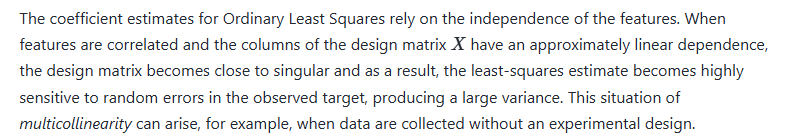




In [ ]:
corrs = data.select_dtypes(exclude=['object']).corr()
upper_tri = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))
upper_tri

,length,diameter,height,whole_weight,hucked_weight,viscera_weight,shell_weight,rings
length,NaN,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
diameter,NaN,NaN,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
height,NaN,NaN,NaN,0.819221,0.774972,0.798319,0.817338,0.557467
whole_weight,NaN,NaN,NaN,NaN,0.969405,0.966375,0.955355,0.540390
hucked_weight,NaN,NaN,NaN,NaN,NaN,0.931961,0.882617,0.420884
viscera_weight,NaN,NaN,NaN,NaN,NaN,NaN,0.907656,0.503819
shell_weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.627574
rings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


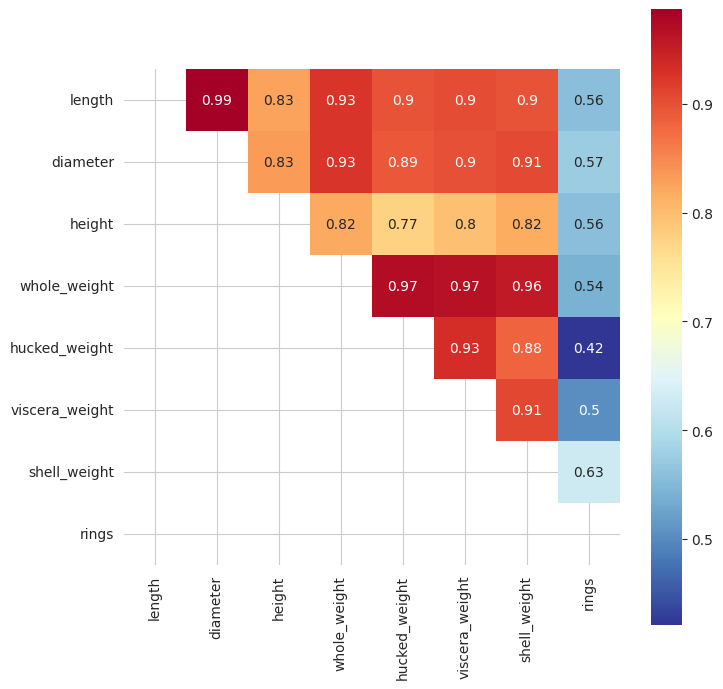

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(upper_tri, cmap="RdYlBu_r", square=True, annot=True);

In [ ]:
cols_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
cols_to_drop

['diameter', 'hucked_weight', 'viscera_weight', 'shell_weight']

In [ ]:
cutted_data = data.drop(columns=cols_to_drop)
cutted_data.head()

,sex,length,height,whole_weight,rings
0,M,0.455,0.095,0.5140,15
1,M,0.350,0.090,0.2255,7
2,F,0.530,0.135,0.6770,9
3,M,0.440,0.125,0.5160,10
4,I,0.330,0.080,0.2050,7


### Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    cutted_data.drop(columns='rings'),
    cutted_data['rings'],
    random_state=2024,
    test_size=0.3
)

In [ ]:
X_train.shape, X_test.shape

((2923, 4), (1254, 4))

### Работа с категориальными признаками

Sex (M: Male, F: Female, I: Infant)

#### Label Encoding

Применяется:

*   если признак является ординальным, т.е. значения связаны отношением порядка
*   в tree-based моделях


In [ ]:
le = LabelEncoder()
le.fit_transform(X_train['sex'])

array([1, 1, 0, ..., 2, 2, 0])

In [ ]:
le.classes_

array(['F', 'I', 'M'], dtype=object)

**NB**

* По задумке создателей Scikit-Learn: `LabelEncoder` - для таргета, `OrdinalEncoder` - для порядковых категориальных переменных, для номинальных - что-нибудь еще...



#### One-Hot Encoding

Применяется:

*   в non-tree-based моделях
*   если у принака невысокая кардинальность



In [ ]:
ohe = OneHotEncoder()
res = ohe.fit_transform(X_train['sex'].to_numpy().reshape(-1, 1))
ohe_df = pd.DataFrame(res.toarray(), columns=ohe.get_feature_names_out())
ohe_df.head()

,x0_F,x0_I,x0_M
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [ ]:
res = pd.get_dummies(X_train['sex'], prefix='sex', drop_first=True)
res.head()

,sex_I,sex_M
1664,True,False
3021,True,False
859,False,False
3274,False,False
994,False,False


**NB**

* `get_dummies` не умеет обрабатывать неизвестные категорию во время преобразования, OHE умеет из коробки
* `get_dummies` несовместим с Scikit-learn Pipeline


### Масштабирование и нормализация

Линейные модели обучения эффективны только на признаках, которые имеют одинаковый масштаб. Поэтому масштабирование признаков это неотъемлемая часть подготовки данных перед применением методов машинного обучения.

**Нормализация**: нормализованный набор данных всегда будет иметь значения в диапазоне от 0 до 1.

**Стандартизация**: стандартизированный набор данных будет иметь среднее значение 0 и стандартное отклонение 1

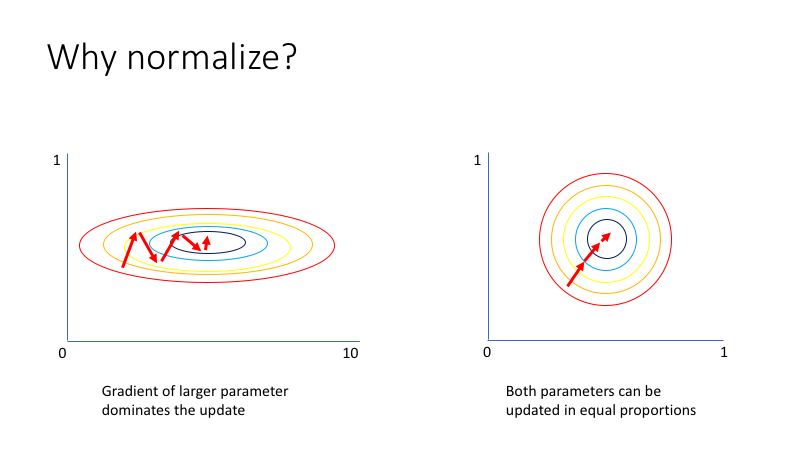

- Более быстрая сходимость алгоритма
- Масштабирование при использовании моделей с регуляризацией позволит штрафовать все признаки одинаково
- Без нормализации "вес" признака представляет собой изменение выхода на единицу изменения в предикторе

Не существует жесткого правила, которое подскажет, когда нормализовать или стандартизировать данные, все зависит от распределения конкретного признака.

В целом нормализацию стоит использовать, когда распределение неизвестно, или известно, что оно не является нормальным.
Полезно использовать, когда данные имеют различный масштаб, а используемый  алгоритм не делает предположений о распределении данных, например, knn и т.д.

Стандартизация предполагает, что данные соответствуют нормальному распределнеию Полезно использовать, когда алгоритм делает предположения о том,  ваши данные имеют нормальное распределение, например линейная регрессия, логистическая регрессия и т.п.


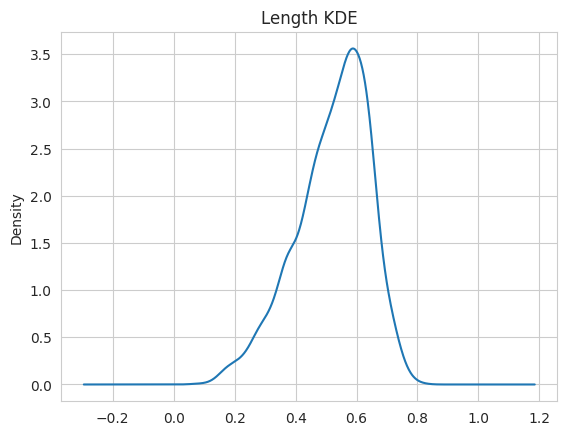

In [ ]:
X_train['length'].plot.kde(title='Length KDE');

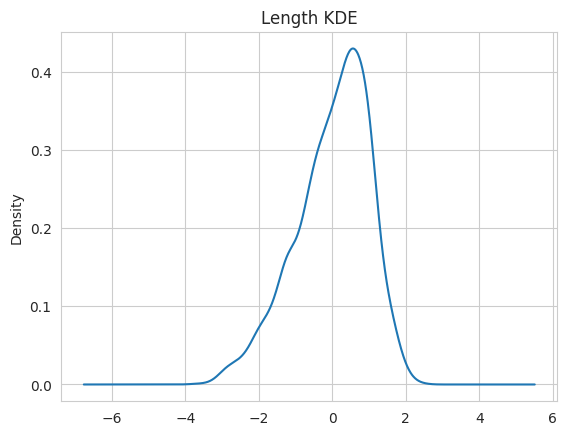

In [ ]:
scaler = StandardScaler()
scaled_ss = scaler.fit_transform(X_train['length'].values.reshape(-1, 1))
scaled_ss = pd.Series(scaled_ss[:, 0])
scaled_ss.plot.kde(title='Length KDE');

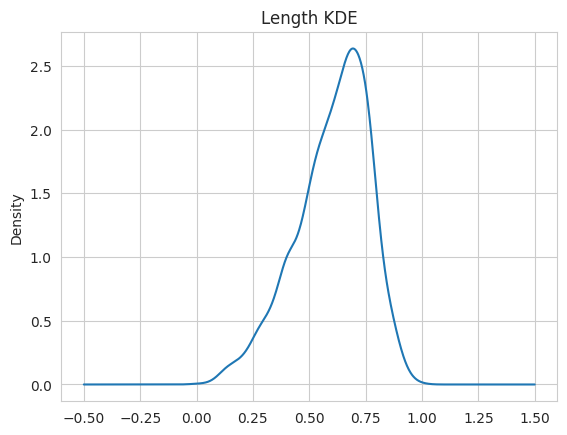

In [ ]:
scaler = MinMaxScaler()
scaled_mm = scaler.fit_transform(X_train['length'].values.reshape(-1, 1))
scaled_mm = pd.Series(scaled_mm[:, 0])
scaled_mm.plot.kde(title='Length KDE');

In [ ]:
res = pd.concat([X_train['length'].describe(), scaled_ss.describe(), scaled_mm.describe()], axis=1)
res.columns = ['length', 'scaled_ss', 'scaled_mm']
with option_context('display.max_colwidth', 700):
  display(res)

,length,scaled_ss,scaled_mm
count,2923.000000,2.923000e+03,2923.000000
mean,0.520787,3.123665e-16,0.602415
std,0.120629,1.000171e+00,0.163013
min,0.075000,-3.696140e+00,0.000000
25%,0.447500,-6.076413e-01,0.503378
50%,0.540000,1.593013e-01,0.628378
75%,0.610000,7.396904e-01,0.722973
max,0.815000,2.439401e+00,1.000000


### Соберем все вместе (снова)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
num_cols = ['length', 'height', 'whole_weight']
cat_cols = ['sex']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop='first'), cat_cols),
    ]
)

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regression", LinearRegression())]
)

In [ ]:
model.fit(X_train, y_train)
y_preds_lr = model.predict(X_test)

In [ ]:
print(f'RMSE: {root_mean_squared_error(y_test, y_preds_lr)}')

RMSE: 2.4474036510082837


### Интерпретация

Если переменные масштабированы, мы можем интерпретировать веса в линейных моделях как важность этой переменной в прогнозируемом результате относительно всех остальных

In [ ]:
def plotCoefficients(model, columns):
    coefs = pd.DataFrame(model.coef_, columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

In [ ]:
new_columns = model['preprocessor'].get_feature_names_out()
new_columns

array(['num__length', 'num__height', 'num__whole_weight', 'cat__sex_I',
       'cat__sex_M'], dtype=object)

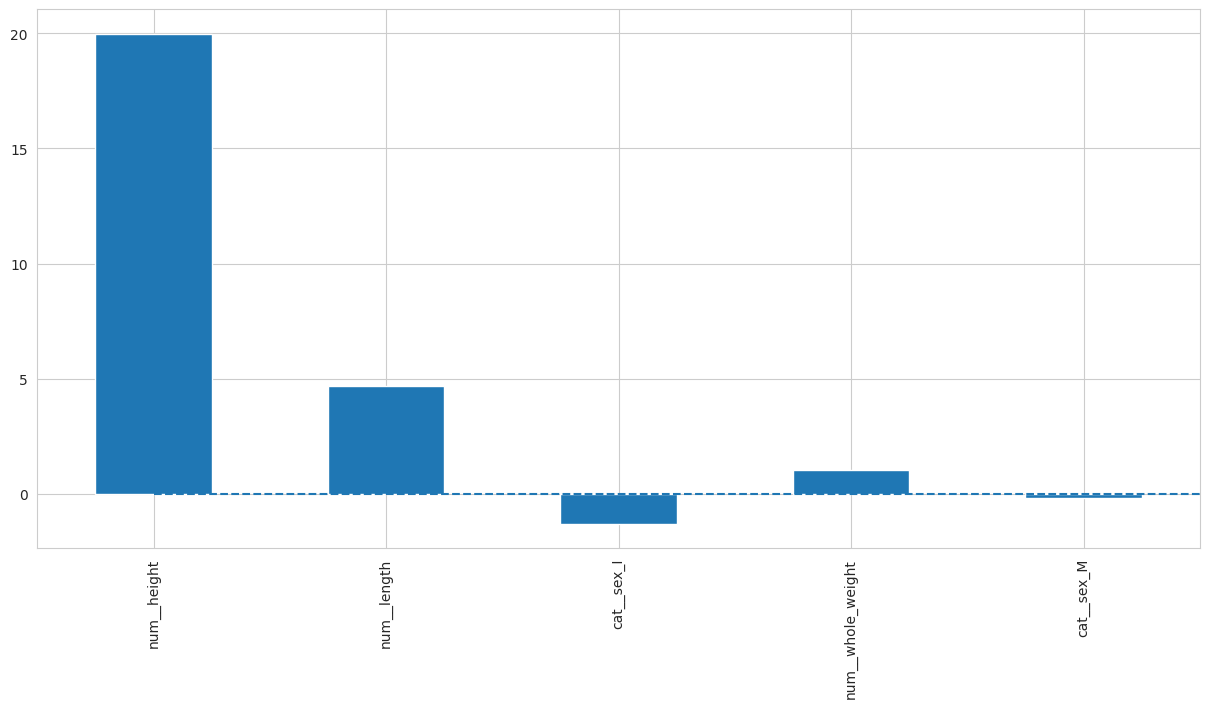

In [ ]:
plotCoefficients(model['regression'], new_columns)

## Линейная регрессия с регуляризацией

Для борьбы с мультиколлинеарностью и переобучением можно использовать регуляризацию - добавление дополнительных ограничений на веса признаков внутри алгоритма

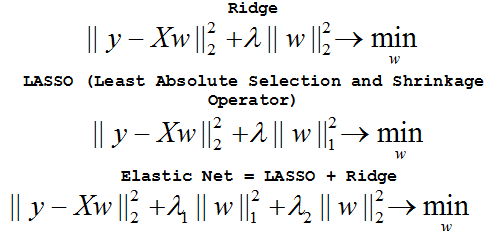

In [ ]:
model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regression", Ridge(alpha=1))]
)
model.fit(X_train, y_train)
y_preds_lr = model.predict(X_test)
print(f'RMSE: {root_mean_squared_error(y_test, y_preds_lr)}')

RMSE: 2.465262425846134


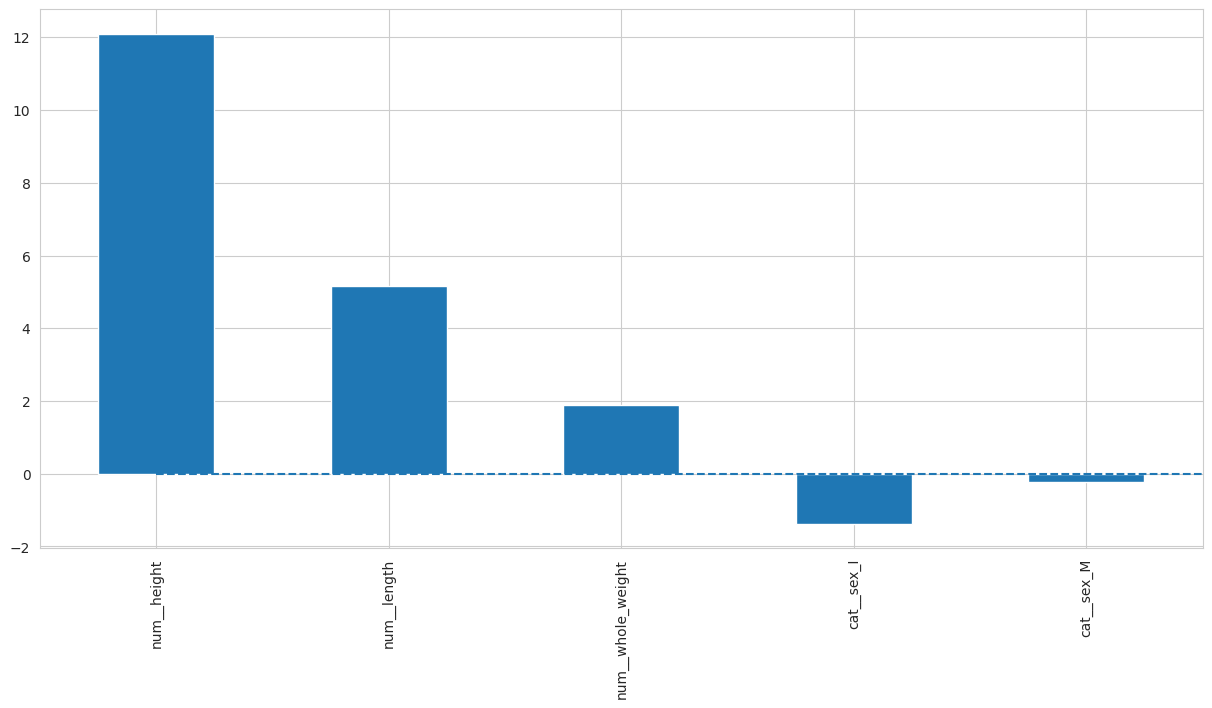

In [ ]:
plotCoefficients(model['regression'], new_columns)

In [ ]:
model = Pipeline(
    steps=[("preprocessor", preprocessor), ("regression", Lasso(alpha=1))]
)
model.fit(X_train, y_train)
y_preds_lr = model.predict(X_test)
print(f'RMSE: {root_mean_squared_error(y_test, y_preds_lr)}')

RMSE: 3.0216700281142788


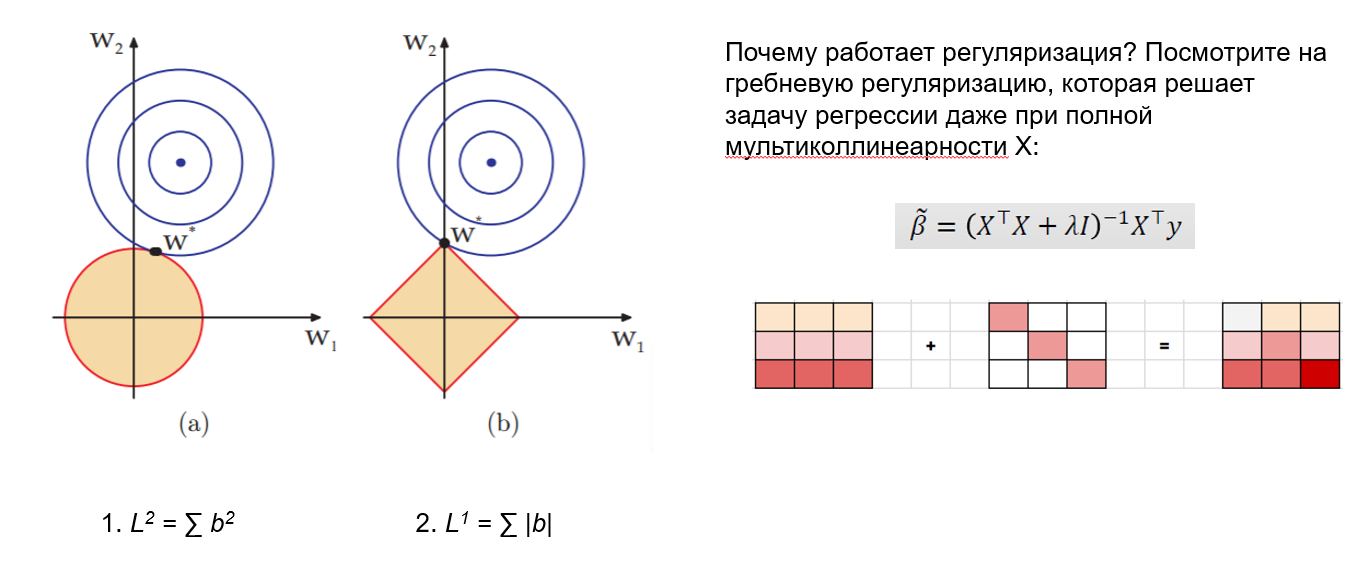

Подробнее можно почитать [тут](https://habr.com/ru/companies/ods/articles/322076/)